In [29]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import random
from IPython.display import clear_output
import time

In [30]:
class BoopGame:
    """
    Boop board game implementation
    - 6x6 board
    - Each player has 8 pieces total (kittens + cats)
    - Pieces boop adjacent pieces when placed
    - 3 kittens in a row graduate to 3 cats
    - Win: 3 cats in a row OR 8 cats on board
    """
    
    def __init__(self, size=6):
        self.size = size
        self.board = np.zeros((size, size), dtype=int)
        # 0 = empty, 1 = player1 kitten, 2 = player2 kitten
        # 3 = player1 cat, 4 = player2 cat
        self.player1_kittens = 8
        self.player2_kittens = 8
        self.player1_cats = 0
        self.player2_cats = 0
        self.current_player = 1
        
        # Track last move for visualization
        self.last_placed_pos = None
        self.affected_positions = []  # Positions of pieces that moved
        self.piece_movements = []  # List of ((from_r, from_c), (to_r, to_c)) or ((from_r, from_c), None)
        
    def get_adjacent_positions(self, row, col):
        """Get all 8 adjacent positions"""
        adjacent = []
        for dr in [-1, 0, 1]:
            for dc in [-1, 0, 1]:
                if dr == 0 and dc == 0:
                    continue
                new_row, new_col = row + dr, col + dc
                if 0 <= new_row < self.size and 0 <= new_col < self.size:
                    adjacent.append((new_row, new_col, dr, dc))
        return adjacent
    
    def boop(self, row, col):
        """Apply boop effect from position (row, col) and return movement information"""
        adjacent = self.get_adjacent_positions(row, col)
        pieces_to_move = []
        
        for adj_row, adj_col, dr, dc in adjacent:
            if self.board[adj_row, adj_col] != 0:
                # Calculate new position
                new_row = adj_row + dr
                new_col = adj_col + dc
                
                # If out of bounds, piece falls off
                if not (0 <= new_row < self.size and 0 <= new_col < self.size):
                    piece_type = self.board[adj_row, adj_col]
                    pieces_to_move.append((adj_row, adj_col, None, None, piece_type))
                # If new position is empty, move there
                elif self.board[new_row, new_col] == 0:
                    pieces_to_move.append((adj_row, adj_col, new_row, new_col, self.board[adj_row, adj_col]))
        
        # Apply moves and track movements
        movements = []
        for old_row, old_col, new_row, new_col, piece_type in pieces_to_move:
            self.board[old_row, old_col] = 0
            if new_row is not None:  # Not falling off
                self.board[new_row, new_col] = piece_type
                movements.append(((old_row, old_col), (new_row, new_col)))
            else:  # Falling off, return pieces to supply
                movements.append(((old_row, old_col), None))
                if piece_type == 1:
                    self.player1_kittens += 1
                elif piece_type == 2:
                    self.player2_kittens += 1
                elif piece_type == 3:
                    self.player1_cats += 1
                elif piece_type == 4:
                    self.player2_cats += 1
        
        return movements
    
    def check_three_in_row(self, piece_type):
        """Check if there are 3 in a row of the given piece type"""
        # Check rows
        for row in range(self.size):
            count = 0
            positions = []
            for col in range(self.size):
                if self.board[row, col] == piece_type:
                    count += 1
                    positions.append((row, col))
                    if count == 3:
                        return positions
                else:
                    count = 0
                    positions = []
        
        # Check columns
        for col in range(self.size):
            count = 0
            positions = []
            for row in range(self.size):
                if self.board[row, col] == piece_type:
                    count += 1
                    positions.append((row, col))
                    if count == 3:
                        return positions
                else:
                    count = 0
                    positions = []
        
        # Check diagonals
        for start_row in range(self.size):
            for start_col in range(self.size):
                # Check down-right diagonal
                count = 0
                positions = []
                for i in range(3):
                    r, c = start_row + i, start_col + i
                    if r < self.size and c < self.size and self.board[r, c] == piece_type:
                        count += 1
                        positions.append((r, c))
                    else:
                        break
                if count == 3:
                    return positions
                
                # Check down-left diagonal
                count = 0
                positions = []
                for i in range(3):
                    r, c = start_row + i, start_col - i
                    if r < self.size and 0 <= c < self.size and self.board[r, c] == piece_type:
                        count += 1
                        positions.append((r, c))
                    else:
                        break
                if count == 3:
                    return positions
        
        return None
    
    def graduate_kittens(self, player):
        """Check for kitten graduation - converts 3 kittens to 3 cats"""
        kitten_type = 1 if player == 1 else 2
        positions = self.check_three_in_row(kitten_type)
        
        if positions:
            # Remove the three kittens from board
            for row, col in positions:
                self.board[row, col] = 0
            
            # Convert to cats in supply (total pieces stays at 8)
            if player == 1:
                self.player1_cats += 3
            else:
                self.player2_cats += 3
            
            return True
        return False
    
    def get_piece_counts_on_board(self, player):
        """Count kittens and cats on board for a player"""
        if player == 1:
            kittens = np.sum(self.board == 1)
            cats = np.sum(self.board == 3)
        else:
            kittens = np.sum(self.board == 2)
            cats = np.sum(self.board == 4)
        return kittens, cats
    
    def check_win(self, player):
        """Check if player has won"""
        cat_type = 3 if player == 1 else 4
        
        # Win condition 1: 3 cats in a row
        if self.check_three_in_row(cat_type):
            return "three_cats"
        
        # Win condition 2: 8 pieces on board with all cats
        kittens_on_board, cats_on_board = self.get_piece_counts_on_board(player)
        total_on_board = kittens_on_board + cats_on_board
        
        if total_on_board >= 8 and kittens_on_board == 0:
            return "eight_cats"
        
        return False
    
    def check_must_graduate(self, player):
        """Check if player must graduate (has 8 pieces on board with kittens)"""
        kittens_on_board, cats_on_board = self.get_piece_counts_on_board(player)
        total_on_board = kittens_on_board + cats_on_board
        
        return total_on_board >= 8 and kittens_on_board > 0
    
    def get_valid_moves(self):
        """Get all empty positions"""
        moves = []
        for row in range(self.size):
            for col in range(self.size):
                if self.board[row, col] == 0:
                    moves.append((row, col))
        return moves
    
    def place_piece(self, row, col):
        """Place a piece for current player"""
        if self.board[row, col] != 0:
            return False
        
        # Determine piece type
        if self.current_player == 1:
            if self.player1_cats > 0:
                piece_type = 3  # Place cat if available
                self.player1_cats -= 1
            elif self.player1_kittens > 0:
                piece_type = 1
                self.player1_kittens -= 1
            else:
                return False
        else:
            if self.player2_cats > 0:
                piece_type = 4
                self.player2_cats -= 1
            elif self.player2_kittens > 0:
                piece_type = 2
                self.player2_kittens -= 1
            else:
                return False
        
        self.board[row, col] = piece_type
        
        # Apply boop effect and track movements
        movements = self.boop(row, col)
        
        # Store movement info for visualization
        self.last_placed_pos = (row, col)
        self.affected_positions = [m[0] for m in movements]  # Original positions of moved pieces
        self.piece_movements = movements
        
        # Check for graduation for both players (pieces might have been booped into alignment)
        opponent = 3 - self.current_player
        self.graduate_kittens(self.current_player)
        self.graduate_kittens(opponent)
        
        # Check win conditions for current player
        win_type = self.check_win(self.current_player)
        if win_type:
            return win_type
        
        # Check if player must graduate (8 pieces with kittens remaining)
        if self.check_must_graduate(self.current_player):
            # Force graduation of 3 kittens
            if self.graduate_kittens(self.current_player):
                # Check win again after forced graduation
                win_type = self.check_win(self.current_player)
                if win_type:
                    return win_type
        
        # Switch player
        self.current_player = 3 - self.current_player
        return True

In [31]:
def display_board(game):
    """Display the current game board state with move visualization"""
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Draw board grid
    for i in range(game.size + 1):
        ax.plot([0, game.size], [i, i], 'k-', linewidth=1)
        ax.plot([i, i], [0, game.size], 'k-', linewidth=1)
    
    # Highlight affected positions (yellow for pieces that moved)
    for row, col in game.affected_positions:
        rect = plt.Rectangle((col, game.size - row - 1), 1, 1, 
                             facecolor='yellow', alpha=0.4, edgecolor='none')
        ax.add_patch(rect)
    
    # Highlight last placed position (green)
    if game.last_placed_pos:
        row, col = game.last_placed_pos
        rect = plt.Rectangle((col, game.size - row - 1), 1, 1, 
                             facecolor='lime', alpha=0.5, edgecolor='none')
        ax.add_patch(rect)
    
    # Draw movement arrows
    for movement in game.piece_movements:
        from_pos, to_pos = movement
        from_row, from_col = from_pos
        
        # Start position (center of original square)
        start_x = from_col + 0.5
        start_y = game.size - from_row - 0.5
        
        if to_pos is None:
            # Piece fell off - arrow points away from board
            to_row, to_col = from_row, from_col
            # Determine direction and extend arrow outside
            mid_x = from_col + 0.5
            mid_y = game.size - from_row - 0.5
            
            # Find the direction (which adjacent cell had the booping piece)
            # The arrow direction is away from center
            # For simplicity, point towards the edge
            dx = (from_col + 0.5 - game.size/2) 
            dy = (game.size - from_row - 0.5 - game.size/2)
            
            # Normalize and extend
            length = max(abs(dx), abs(dy))
            if length > 0:
                dx, dy = dx/length, dy/length
            else:
                dx, dy = 1, 0
            
            end_x = start_x + dx * 0.8
            end_y = start_y + dy * 0.8
        else:
            # Piece moved to new position
            to_row, to_col = to_pos
            end_x = to_col + 0.5
            end_y = game.size - to_row - 0.5
        
        # Draw arrow
        ax.arrow(start_x, start_y, end_x - start_x, end_y - start_y,
                head_width=0.15, head_length=0.1, fc='red', ec='red', alpha=0.6)
    
    # Draw pieces
    for row in range(game.size):
        for col in range(game.size):
            piece = game.board[row, col]
            if piece != 0:
                x, y = col + 0.5, game.size - row - 0.5
                
                if piece in [1, 3]:  # Player 1
                    color = 'orange'
                else:  # Player 2
                    color = 'gray'
                
                if piece in [1, 2]:  # Kitten
                    radius = 0.3
                else:  # Cat
                    radius = 0.4
                
                circle = Circle((x, y), radius, color=color, ec='black', linewidth=2)
                ax.add_patch(circle)
    
    ax.set_xlim(0, game.size)
    ax.set_ylim(0, game.size)
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Get board composition
    p1_kittens_on_board, p1_cats_on_board = game.get_piece_counts_on_board(1)
    p2_kittens_on_board, p2_cats_on_board = game.get_piece_counts_on_board(2)
    
    # Calculate totals to verify constraint
    p1_total = game.player1_kittens + game.player1_cats + p1_kittens_on_board + p1_cats_on_board
    p2_total = game.player2_kittens + game.player2_cats + p2_kittens_on_board + p2_cats_on_board
    
    # Add title with game state
    title = f"Player {game.current_player}'s turn\n"
    title += f"P1 Supply: {game.player1_kittens}🐱 {game.player1_cats}🐈 | "
    title += f"Board: {p1_kittens_on_board}🐱 {p1_cats_on_board}🐈 | Total: {p1_total}/8\n"
    title += f"P2 Supply: {game.player2_kittens}🐱 {game.player2_cats}🐈 | "
    title += f"Board: {p2_kittens_on_board}🐱 {p2_cats_on_board}🐈 | Total: {p2_total}/8"
    ax.set_title(title, fontsize=11, pad=20)
    
    plt.tight_layout()
    plt.show()

In [32]:
def play_automated_game(delay=0.5, max_moves=100):
    """
    Run an automated game with random moves
    
    Parameters:
    - delay: time between moves in seconds
    - max_moves: maximum number of moves before declaring a draw
    """
    game = BoopGame()
    move_count = 0
    
    print("Starting automated boop game...")
    print("Orange = Player 1, Gray = Player 2")
    print("Small circles = kittens, Large circles = cats\n")
    
    while move_count < max_moves:
        clear_output(wait=True)
        display_board(game)
        
        # Get valid moves
        valid_moves = game.get_valid_moves()
        if not valid_moves:
            print("No valid moves available!")
            break
        
        # Random move
        row, col = random.choice(valid_moves)
        print(f"Move {move_count + 1}: Player {game.current_player} places at ({row}, {col})")
        
        result = game.place_piece(row, col)
        
        if result in ["three_cats", "eight_cats"]:
            clear_output(wait=True)
            display_board(game)
            winner = 3 - game.current_player  # Previous player won
            win_msg = "3 cats in a row!" if result == "three_cats" else "8 cats on board!"
            print(f"\n🎉 Player {winner} wins with {win_msg} 🎉")
            break
        
        move_count += 1
        time.sleep(delay)
    
    if move_count >= max_moves:
        print(f"\nGame ended after {max_moves} moves (draw)")
    
    return game

KeyboardInterrupt: 

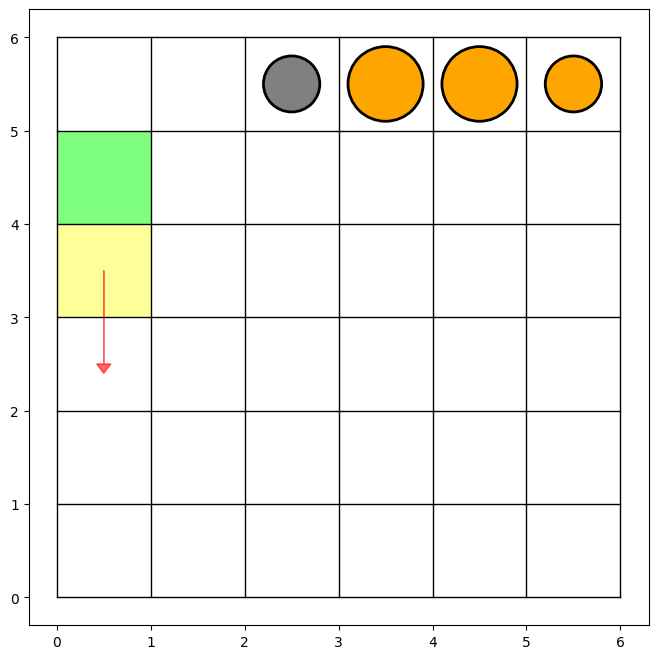

In [33]:
# Run an automated game
game = play_automated_game(delay=.5, max_moves=300)

Initial board state:


/tmp/ipykernel_11203/112378745.py:51: UserWarning: Glyph 128008 (\N{CAT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


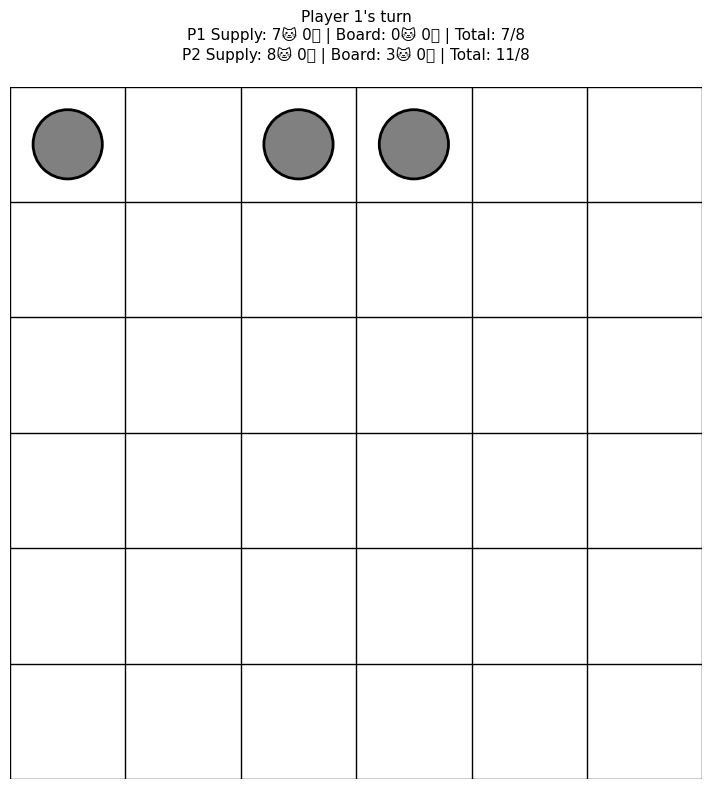


Player 1 places at (0, 1) - this should boop (0,0) left and (0,2) right
After boop, if (0,0) falls off and pieces shift, there might be 3 in a row

Result: True

Board after move:


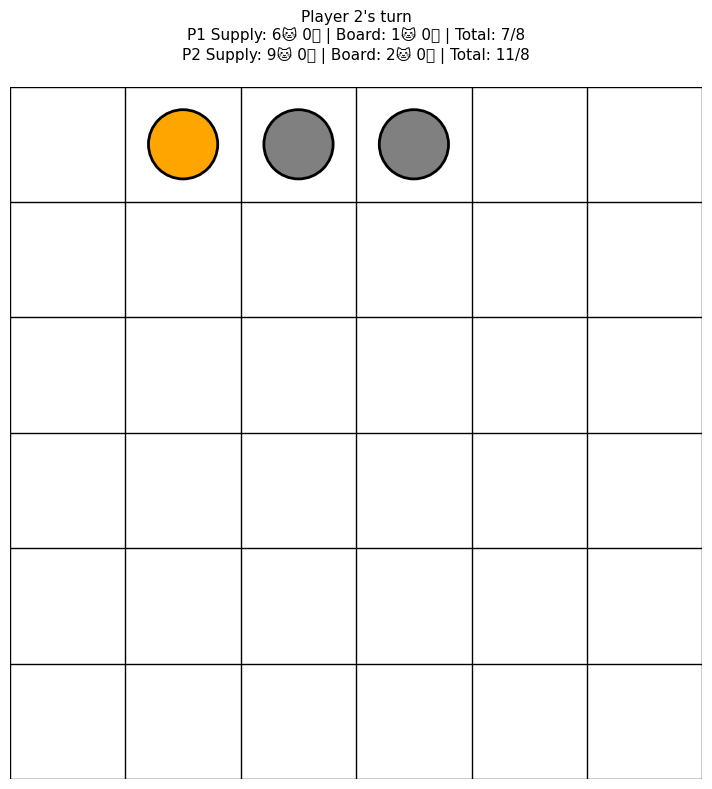

In [ ]:
# Test: Create a scenario where booping causes opponent graduation
test_game = BoopGame()

# Setup: Place player 2 kittens in a near-row formation
# We'll place them at positions where a boop could align them
test_game.board[0, 0] = 2  # P2 kitten
test_game.board[0, 2] = 2  # P2 kitten  
test_game.board[0, 3] = 2  # P2 kitten

# Place player 1 kitten that will boop them together
test_game.current_player = 1
test_game.player1_kittens = 7

print("Initial board state:")
display_board(test_game)

print("\nPlayer 1 places at (0, 1) - this should boop (0,0) left and (0,2) right")
print("After boop, if (0,0) falls off and pieces shift, there might be 3 in a row")

# Try the move
result = test_game.place_piece(0, 1)

print(f"\nResult: {result}")
print("\nBoard after move:")
display_board(test_game)

Test 2: Setup where P1 move causes P2 pieces to align


/tmp/ipykernel_11203/1981289421.py:105: UserWarning: Glyph 128008 (\N{CAT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


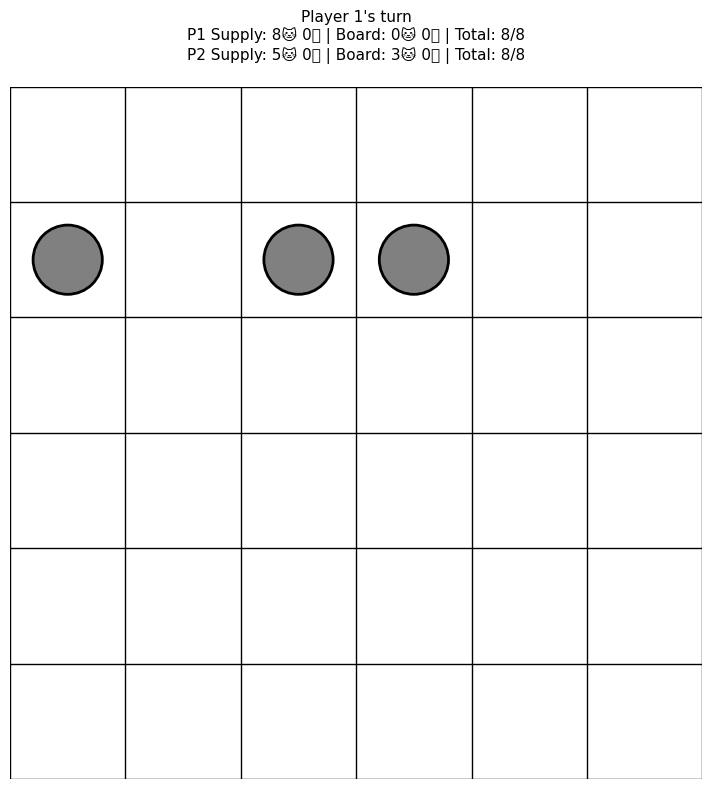


After P1 places at (1,1), result: True


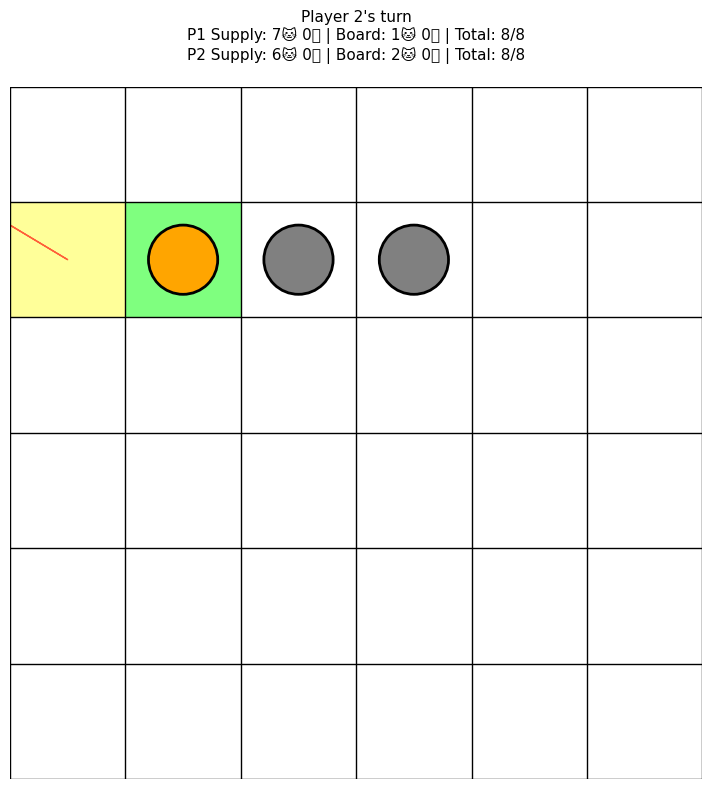


P2 total pieces: 8 (should be 8)


In [ ]:
# Test 2: Proper test with piece accounting
test_game2 = BoopGame()

# Manually place pieces by reducing supply correctly
# Place 3 P2 kittens that are almost in a row
test_game2.board[1, 0] = 2  
test_game2.board[1, 2] = 2  
test_game2.board[1, 3] = 2
test_game2.player2_kittens = 5  # Started with 8, placed 3

print("Test 2: Setup where P1 move causes P2 pieces to align")
display_board(test_game2)

# P1 places between them
test_game2.current_player = 1
result = test_game2.place_piece(1, 1)

print(f"\nAfter P1 places at (1,1), result: {result}")
display_board(test_game2)

# Check piece counts
p2_kittens, p2_cats = test_game2.get_piece_counts_on_board(2)
total = test_game2.player2_kittens + test_game2.player2_cats + p2_kittens + p2_cats
print(f"\nP2 total pieces: {total} (should be 8)")

Test 3: P2 has kittens that will align when booped
P2 kittens at: (2,1), (2,2), (3,3)


/tmp/ipykernel_11203/112378745.py:51: UserWarning: Glyph 128008 (\N{CAT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


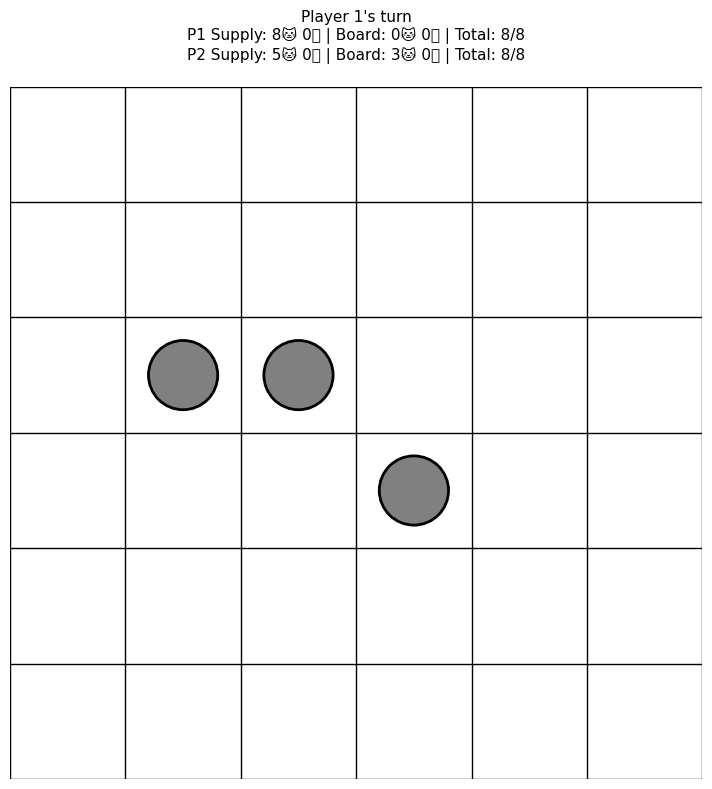



Better setup: P2 kittens at (2,0), (2,1), (1,2)


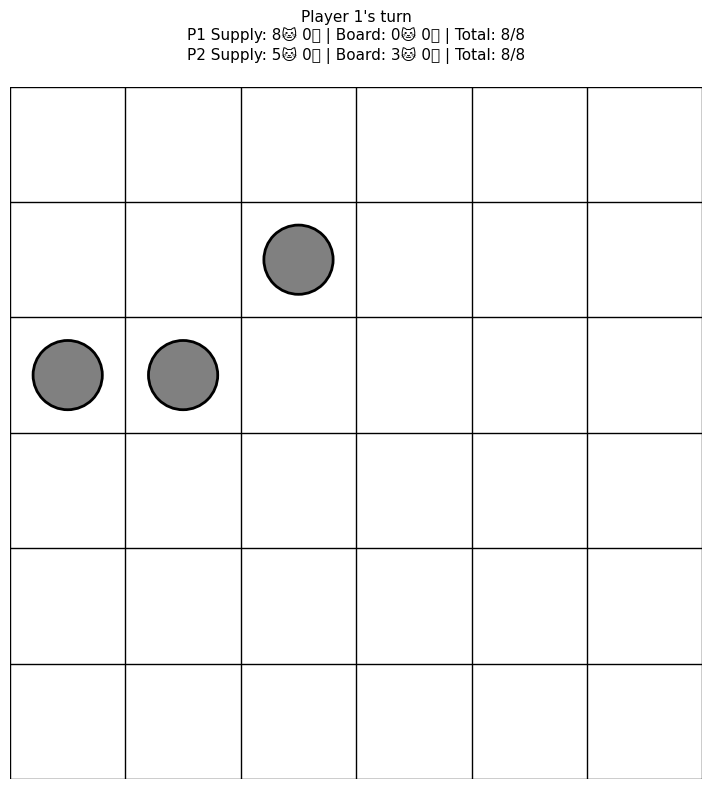


P1 places at (0,2) - should boop (1,2) down to (2,2)

Result: True


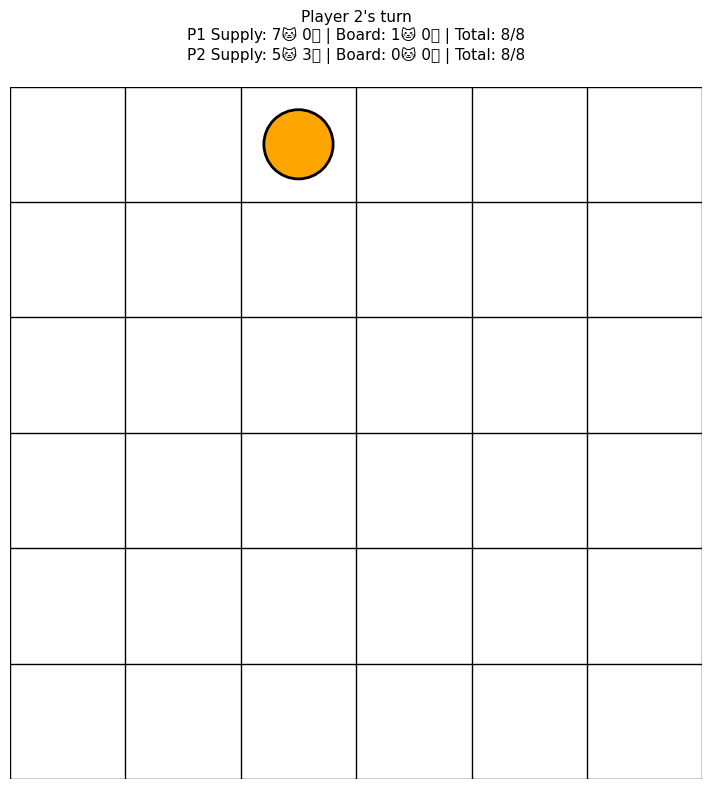


P2 cats in supply: 3 (should be 3 if graduation occurred)


In [ ]:
# Test 3: Force a scenario where booping creates 3 in a row for opponent
test_game3 = BoopGame()

# Setup: P2 has 2 kittens next to each other, and 1 kitten nearby
# When P1 boops, it should push the 3rd kitten into alignment
test_game3.board[2, 1] = 2  # P2 kitten
test_game3.board[2, 2] = 2  # P2 kitten
test_game3.board[3, 3] = 2  # P2 kitten (will be booped into position)
test_game3.player2_kittens = 5  # 8 - 3 placed

print("Test 3: P2 has kittens that will align when booped")
print("P2 kittens at: (2,1), (2,2), (3,3)")
display_board(test_game3)

# P1 places at (3,2) which should boop (3,3) left to (3,2) - wait, that's occupied
# Let me try a different setup...

test_game3 = BoopGame()
test_game3.board[2, 0] = 2  # P2 kitten
test_game3.board[2, 1] = 2  # P2 kitten  
test_game3.board[1, 2] = 2  # P2 kitten (will be booped down-left)
test_game3.player2_kittens = 5

print("\n\nBetter setup: P2 kittens at (2,0), (2,1), (1,2)")
display_board(test_game3)

# P1 places at (0,3) - should boop (1,2) diagonally
print("\nP1 places at (0,2) - should boop (1,2) down to (2,2)")
test_game3.current_player = 1  
result = test_game3.place_piece(0, 2)

print(f"\nResult: {result}")
display_board(test_game3)

# Check if graduation happened
p2_supply_cats = test_game3.player2_cats
print(f"\nP2 cats in supply: {p2_supply_cats} (should be 3 if graduation occurred)")